In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 85)
sns.set_theme(context="paper", font_scale=1.5, style="ticks", rc={"axes.grid": True})

# Support Vector Machine Classifier: Feature Importance by Permutation

***
## Load the data

In [2]:
# Read Data from CSV (NEW DATA, NOT SCALED)
df = pd.read_csv("../data/abnormal_writeout_noscale.data.csv", index_col=0)

# trascurare da ACC a UVM
start_drop = df.columns.get_loc("ACC")
end_drop = df.columns.get_loc("UVM")
cols = np.arange(start_drop, end_drop + 1)
df.drop(df.columns[cols], axis=1, inplace=True)

# trascurare alcune colonne
df.drop("TTT_freq", axis=1, inplace=True)
df.drop("oldest_phylostratum_factor", axis=1, inplace=True)

# Drop NaNs
df.dropna(inplace=True)

# Sort features
resp = df["response"]
occ = df["occ_total_sum"]
age = df["oldest_phylostratum"]
conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1)

# Collect Features and Labels
features_df = pd.DataFrame()
features_df["occ_total_sum"] = occ
features_df["oldest_phylostratum"] = age
features_df = pd.concat([features_df, conf], axis=1)

X = features_df.to_numpy()
y = df["response"].to_numpy()

features_df.head(10)

,occ_total_sum,oldest_phylostratum,cds_length,gc_cds,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.657258,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.422680,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.572344,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.460000,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.401617,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.0

## Custom PCA

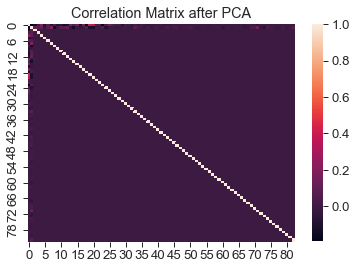

83 total features.
Confounder columns start from index 2 of feature matrix.
Non-counfounders: ['occ_total_sum', 'oldest_phylostratum']


,occ_total_sum,oldest_phylostratum,cds_length,gc_cds,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.657258,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.422680,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.572344,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.460000,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.401617,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.0

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Columns of confounder variables (highly colinear)
conf_index = 2
conf_cols = np.arange(2, X.shape[1])


class ConfounderPCA(BaseEstimator, TransformerMixin):
    """ 
    Custom PCA transformer for this dataset.
    Applies PCA only to the many collinear confounder 
    variables.
    
    cols - columns to which PCA will be applied.
    
    n_components - same as with the "vanilla" PCA. 
        If 0 < n_components < 1, select the number of 
        components such that the amount of variance that 
        needs to be explained is greater than the 
        percentage specified by n_components.
        
    apply_PCA - if false, simply returns the untransformed data.
    """

    def __init__(self, cols, n_components=None, apply_PCA=True):
        self.n_components = n_components
        self.apply_PCA = apply_PCA
        self.cols = cols
        if self.apply_PCA:
            self.pca = PCA(n_components=self.n_components)

    def fit(self, X, y=None):
        if self.apply_PCA:
            self.pca.fit(X[:, self.cols])
        return self

    def transform(self, X, y=None):
        if self.apply_PCA:
            X_pca = self.pca.transform(X[:, self.cols])
            return np.c_[X[:, :2], X_pca]
        else:
            return X


sns.heatmap(
    pd.DataFrame(
        ConfounderPCA(cols=np.arange(2, X.shape[1])).fit_transform(StandardScaler().fit_transform(X))
    ).corr()
)
plt.title("Correlation Matrix after PCA")
plt.show()

print(X.shape[1], "total features.")
print("Confounder columns start from index", conf_index, "of feature matrix.")
print("Non-counfounders:", features_df.iloc[:, 0:conf_index].columns.tolist())

features_df

# Feature importance by Permutation

In [4]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

def calc_importances(model, x, y, ranseed=0):
    
    # Train/test split
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=ranseed)

    # Train the model on the dataset
    model.fit(x_tr, y_tr) 
    
    # Compare the model against other models trained on permutations of the dataset
    results = permutation_importance(model, x_te, y_te, n_repeats=5, random_state=ranseed, scoring='roc_auc', n_jobs=-1)
    
    return pd.DataFrame(results.importances_mean, columns=["Score"], index=features_df.columns)

### PCA, Dropping Components to 95% Explained Variance

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", ConfounderPCA(cols=np.arange(2, X.shape[1]), n_components=0.95)),
    ("svc", SVC(kernel='rbf', probability=True)),
])

imp_pca_df = calc_importances(svm_clf, X, y, ranseed=42) 

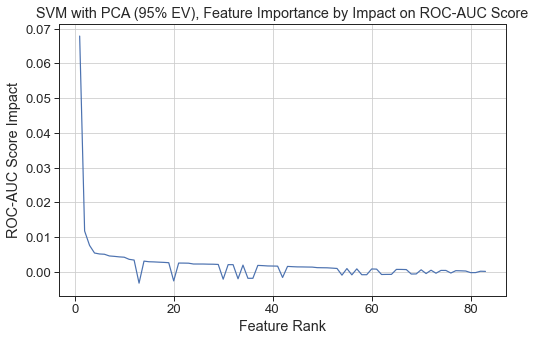

,Score
occ_total_sum,0.067863
oldest_phylostratum,0.011752
cds_length,0.007605
ATG_freq,0.005414
CAC_freq,0.005141
TGG_freq,0.005059
ATC_freq,0.004567
CCA_freq,0.004452
H3k4me1_cds,0.004301
TGA_freq,0.004207


In [6]:
data = imp_pca_df.sort_values(by="Score", key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(1, 84), y=data.to_numpy().flatten())
plt.title("SVM with PCA (95% EV), Feature Importance by Impact on ROC-AUC Score")
plt.ylabel("ROC-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.show()

# Print the feature matrix sorted by importance
data.head(10)

### Without PCA

In [8]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    # ("pca", ConfounderPCA(cols=np.arange(2, X.shape[1]), n_components=0.95)),
    ("svc", SVC(kernel='rbf', probability=True)),
])

imp_npca_df = calc_importances(svm_clf, X, y, ranseed=30) 

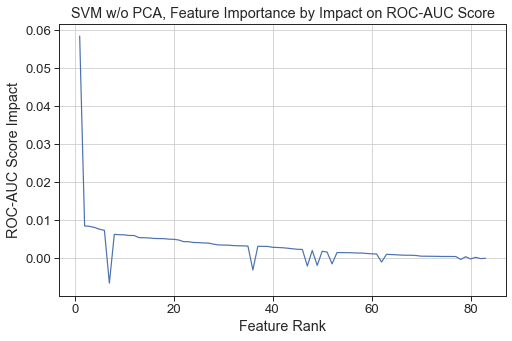

,Score
occ_total_sum,0.058348
AGT_freq,0.008451
oldest_phylostratum,0.008339
AAA_freq,0.008056
CCC_freq,0.007584
AAT_freq,0.007283
cds_length,-0.006586
TAT_freq,0.006234
CCA_freq,0.006145
TAC_freq,0.006109


In [9]:
data = imp_npca_df.sort_values(by="Score", key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(1, 84), y=data.to_numpy().flatten())
plt.title("SVM w/o PCA, Feature Importance by Impact on ROC-AUC Score")
plt.ylabel("ROC-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.show()

# Print the feature matrix sorted by importance
data.head(10)

### Without dropping components

In [10]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", ConfounderPCA(cols=np.arange(2, X.shape[1]), n_components=None)),
    ("svc", SVC(kernel='rbf', probability=True)),
])

imp_pca_all_df = calc_importances(svm_clf, X, y, ranseed=44) 

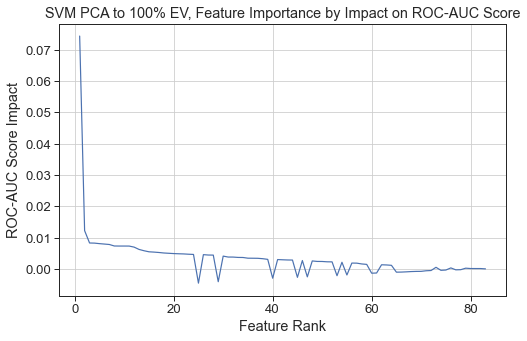

,Score
occ_total_sum,0.074350
GTG_freq,0.012204
TAT_freq,0.008265
GTC_freq,0.008226
TAC_freq,0.008059
GCG_freq,0.007925
GAC_freq,0.007788
GGA_freq,0.007308
TTA_freq,0.007291
oldest_phylostratum,0.007290


In [11]:
data = imp_pca_all_df.sort_values(by="Score", key=abs, ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(1, 84), y=data.to_numpy().flatten())
plt.title("SVM PCA to 100% EV, Feature Importance by Impact on ROC-AUC Score")
plt.ylabel("ROC-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.show()

# Print the feature matrix sorted by importance
data.head(10)

## Results Summary

In [12]:
results_df = pd.DataFrame()

results_df["Top Variables PCA 95%"] = imp_pca_df.sort_values(by="Score", key=abs, ascending=False).index
results_df["Scores PCA 95%"] = imp_pca_df.sort_values(by="Score", key=abs, ascending=False).Score.to_numpy()

results_df["Top Variables PCA 100%"] = imp_pca_all_df.sort_values(by="Score", key=abs, ascending=False).index
results_df["Scores PCA 100%"] = imp_pca_all_df.sort_values(by="Score", key=abs, ascending=False).Score.to_numpy()

results_df["Top Variables No PCA"] = imp_npca_df.sort_values(by="Score", key=abs, ascending=False).index
results_df["Scores No PCA"] = imp_npca_df.sort_values(by="Score", key=abs, ascending=False).Score.to_numpy()

results_df.head(10)

,Top Variables PCA 95%,Scores PCA 95%,Top Variables PCA 100%,Scores PCA 100%,Top Variables No PCA,Scores No PCA
0,occ_total_sum,0.067863,occ_total_sum,0.074350,occ_total_sum,0.058348
1,oldest_phylostratum,0.011752,GTG_freq,0.012204,AGT_freq,0.008451
2,cds_length,0.007605,TAT_freq,0.008265,oldest_phylostratum,0.008339
3,ATG_freq,0.005414,GTC_freq,0.008226,AAA_freq,0.008056
4,CAC_freq,0.005141,TAC_freq,0.008059,CCC_freq,0.007584
5,TGG_freq,0.005059,GCG_freq,0.007925,AAT_freq,0.007283
6,ATC_freq,0.004567,GAC_freq,0.007788,cds_length,-0.006586
7,CCA_freq,0.004452,GGA_freq,0.007308,TAT_freq,0.006234
8,H3k4me1_cds,0.004301,TTA_freq,0.007291,CCA_freq,0.006145
9,TGA_freq,0.004207,oldest_phylostratum,0.007290,TAC_freq,0.006109


In [13]:
pd.set_option("display.max_rows", 83)
results_df.to_markdown("./SVM_FI.md")
results_df.to_csv("./SVM_FI.csv")

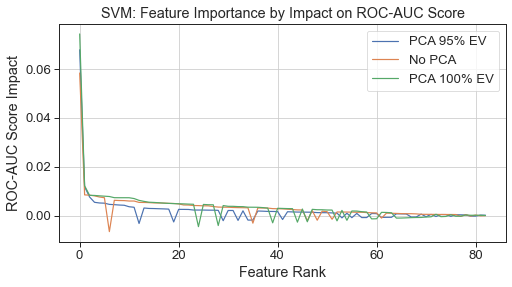

In [14]:
plt.figure(figsize=(8,4))

sns.lineplot(x=np.arange(83), y=results_df["Scores PCA 95%"].to_numpy().flatten(), label="PCA 95% EV")
sns.lineplot(x=np.arange(83), y=results_df["Scores No PCA"].to_numpy().flatten(), label="No PCA") 
sns.lineplot(x=np.arange(83), y=results_df["Scores PCA 100%"].to_numpy().flatten(), label="PCA 100% EV") 
plt.title("SVM: Feature Importance by Impact on ROC-AUC Score")
plt.ylabel("ROC-AUC Score Impact")
plt.xlabel("Feature Rank")
plt.grid(True)
plt.savefig("./figures/SVM_FI.png")
plt.show()